# Overview

Simulation of M2 measurement of a laser beam subject to spherical aberrations as discussed in Wirthl2021, and recreating figures of Bey2013.

Written by Lothar Maisenbacher for the 2S-nP hydrogen spectroscopy project at MPQ.

Part of my collection of diffraction scripts in `https://gitlab.mpcdf.mpg.de/lmaisen/diffractioncalc`.

# References
Siegman1986:
Siegman, Anthony E. Lasers. University Science Books, 1986.

Wirthl2021:
Wirthl, Vitaly, Lothar Maisenbacher, Johannes Weitenberg, Alexander Hertlein, Alexey Grinin, Arthur Matveev, et al. “Improved Active Fiber-Based Retroreflector with Intensity Stabilization and a Polarization Monitor for the near UV.” Optics Express 29, no. 5 (March 1, 2021): 7024–48. https://doi.org/10.1364/OE.417455.

MaisenbacherThesis:
Maisenbacher, Lothar. “Precision Spectroscopy of the 2S-nP Transitions in Atomic Hydrogen.” PhD, Ludwig-Maximilians-Universität München, 2020.

Bey2013:
Bey, Nadine. “Spektral Aufgelöste Strahlqualitätsmessung.” Master’s thesis, RWTH Aachen, 2013.

In [1]:
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits
import scipy.optimize
import scipy.special
import scipy.integrate
import logging

import gaussian_beam

In [2]:
logging.basicConfig()
logger = logging.getLogger()
# Switch on debug output of poppy (containing information on which algorithms are used)
# logger.setLevel(logging.DEBUG)
# Switch off debug output of poppy (containing information on which algorithms are used)
logger.setLevel(logging.INFO)

In [3]:
def fresnel_integral_kernel(r, rd, z, wavelength):
    """
    Integral kernel of the Fresnel approximation to Kirchhoff's diffraction formula
    (see Siegman1986, Ch. 16, Eq. (18)).
    In cylindrical coordinates for rotationally symmetry input field.
    Gives the electric field at point (`r`, `z`), with `r` radial position and `z` object
    distance, originating from point (`rd`, `0`), for wavelength `wavelength`.
    """
    k0 = 2*np.pi/wavelength
    return (
        1j*2*np.pi/(z*wavelength)
        * np.exp(-1j*k0*z)
        * np.exp(-1j*k0*r**2/2/z)
        * rd
        * np.exp(-1j*k0*rd**2/2/z)
        * scipy.special.jv(0, k0*r*rd/z)
        )

def calc_fresnel_disc_e(rd, Ed, r, z, wavelength):
    """
    Discrete, explicit evaluation of Fresnel diffraction for an electric field `Ed` given at
    discrete sampled points `rd`, e.g., from ZEMAX POP, to a plane at distance `z` and sampled at
    points `r`. The wavelength is given by `wavelength`.
    Note however that a large number of points is needed to give satisfactory results, which might
    not be available. In this case, one can interpolate the electric field first,
    granted that it is sufficiently smooth, and then integrate this function.
    """
    DiffIntReal = lambda r: np.real(fresnel_integral_kernel(r, rd, z, wavelength)*Ed)
    DiffIntImag = lambda r: np.imag(fresnel_integral_kernel(r, rd, z, wavelength)*Ed)

    diff_er = np.zeros(len(r), dtype=np.complex128)
    for i, ra in enumerate(r):
        a = scipy.integrate.trapz(DiffIntReal(ra),rd)
        b = scipy.integrate.trapz(DiffIntImag(ra),rd)
        diff_er[i] = a+1j*b

    return diff_er  

def add_wavefront_curvature(wf, roc):
    """Add wavefront curvature with radius of curvature of `roc` to poppy field `wf`."""
    Y, X = wf.coordinates()
    k = 2*np.pi/wf.wavelength.to('m').value
    wf.wavefront *= np.exp(1j*k/(2*roc.to('m').value)*(X**2+Y**2))
    return wf

def add_lens_phase(wf, f):
    """
    Add wavefront curvature corresponding to the action of a lens with focal length `f` to
    poppy field `wf`.
    Cf. Eq. (4) of Wirthl2021, which however has a sign incompatible (-) with the convention used in
    the rest of the paper. We here instead use a positive phase for a converging lens, which
    corresponds to the spatial propagation phase of a wave to `-kz`.
    """
    Y, X = wf.coordinates()
    k = 2*np.pi/wf.wavelength.to('m').value
    wf.wavefront *= np.exp(1j*k/(2*f.to('m').value)*(X**2+Y**2))
    return wf

def add_spherical_aberration_phase(wf, s, w):
    """
    Add wavefront curvature corresponding to spherical aberration with strength `s`
    to the poppy field `wf` with the beam radius `w`.
    The focusing effect of the spherical aberration is removed by the quadratic term.
    Cf. Eq. (4) of Wirthl2021. Sign corresponds to spatial propagation phase of `-kz`.
    """
    Y, X = wf.coordinates()
    wf.wavefront *= np.exp(
        1j*s*(
            ((X**4+Y**4)/w.to('m').value**4)
            -(2*(X**2+Y**2)/w.to('m').value**2)))    
    return wf

def abcd_thin_lens(f):
    """ABCD matrix for thin lens with focal length `f`."""
    invf = np.inf if f == 0 else 1/f
    return np.array(((1, 0), (-invf, 1)))

gaussian_profile_1d = lambda x, w: np.exp(-x**2/w**2)
gaussian_profile_int_1d = lambda x, w: np.exp(-2*x**2/w**2)

30.649684425266265 m
0.002 m
5.11e-06


Text(0, 0.5, 'Phase (rad)')

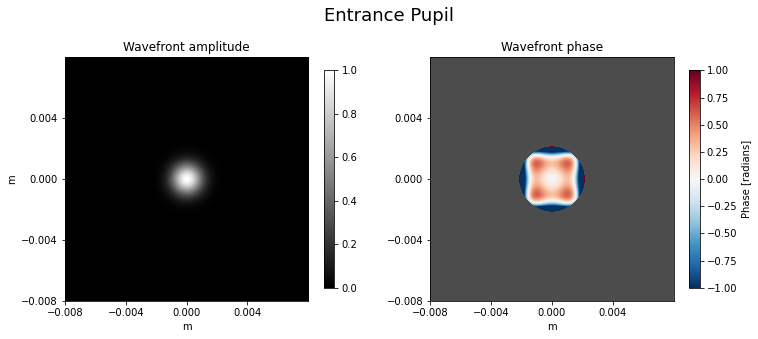

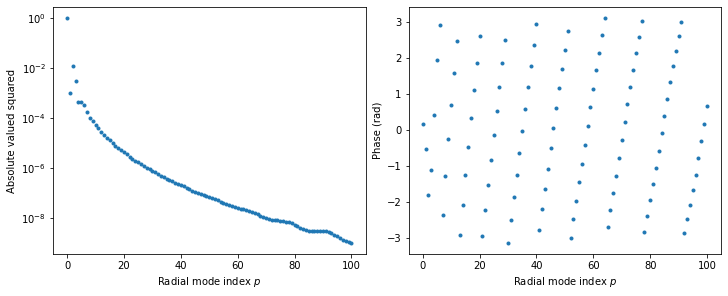

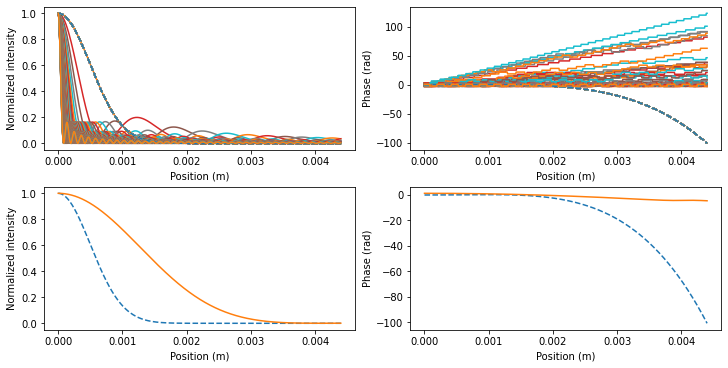

In [4]:
# Oversampling, i.e., factor by which sample size will be increased
# to suppress FFT artifacts
num_oversample = 4
# Number of iterations of Fox-Li method
num_iter = 20

aperture_func = None
initial_wavefront_roc = None
initial_s = None

# Three-lens collimator for hydrogen 2S-6P spectroscopy discussed in Wirthl2021
# Wavelength
wavelength = 410*u.nm
# Number of pixels in sample
num_pixels = 1024
# Aperture function
aperture_func = None
# Start beam profile
initial_gaussian_radius = 1.*u.mm
# Physical sample size (full width)
sample_size = 4*initial_gaussian_radius
# Initial wavefront curvature radius
initial_wavefront_roc = None
# Add spherical aberration with strength `s`
# Note that the sign of the strength here is opposite to that of Wirthl2021,
# but the convention of Eq. (4) of Wirthl2021 are kept. This is because of a sign difference
# in the Fresnel integral kernel used here and in Wirthl2021. The sign choice here makes sure that
# a beam that goes through a convex lens, i.e., that adds more phase in the center of the lens,
# is focused as it propagates along the positive z-direction.
initial_s = -0.3

num_oversamples = num_pixels*num_oversample
ind_c = num_oversamples//2
oversample_size = sample_size*num_oversample
x = np.arange(num_oversamples)/(num_oversamples)*oversample_size-oversample_size/2
hroundtrips = np.arange(num_iter+1)

# Empty arrays
wavefront_cuts = np.zeros((num_iter+1, num_oversamples), dtype=np.complex128)
wavefronts = np.zeros((num_iter+1, num_oversamples, num_oversamples), dtype=np.complex128)

# Initial field
wf = poppy.FresnelWavefront(
    sample_size/2, wavelength=wavelength,
    npix=num_pixels, oversample=num_oversample)

# Set-up Gaussian beam with given radius and wavefront curvature
beam = gaussian_beam.GaussianBeam(
    q=0, wavelength=wavelength.to('m').value, w0=initial_gaussian_radius.to('m').value)
Y, X = wf.coordinates()
wf.wavefront = beam.laguerre_gauss(0, 0, np.sqrt(X**2+Y**2), np.arctan2(Y, X))
wf.wavefront /= np.abs(wf.wavefront.max())
wf.wavefront = wf.wavefront.astype(np.complex128)
# if initial_wavefront_roc is not None:
#     wf = add_wavefront_curvature(wf, initial_wavefront_roc)

if aperture_func is not None:
    wf *= aperture_func

# Add spherical aberration with strength `s_param`
if initial_s is not None:
    wf = add_spherical_aberration_phase(wf, initial_s, initial_gaussian_radius)

print(wf.z_r.to('m'))
print(wf.w_0.to('m'))

wavefront_cuts[0] = wf.wavefront[ind_c, :]
wf_initial = wf.copy()
wavefronts[0] = wf.wavefront

plt.figure(figsize=(12, 5))
wf.display('both', colorbar=True, showpadding=True)
plt.suptitle("Entrance Pupil", fontsize=18)

# Find decomposition of calculated beam into Laguerre-Gauss modes

# Max. value of radial mode index `p` of Laguerre-Gauss modes to include
p_max = 100

mask = (x >= 0) & (x <= 1.1*sample_size)
r = x[mask].to('m').value

# Calculated beam
wf_calc = wf.copy()
calc = wf_calc.wavefront[ind_c, mask]
calc_norm_const = np.sqrt(scipy.integrate.trapezoid(2*np.pi*r*calc*np.conjugate(calc), r))
calc /= calc_norm_const

ps = np.arange(0, p_max+1)
coeffs = np.zeros(p_max+1, dtype=np.complex128)
for p in range(p_max+1):
    mode = beam.laguerre_gauss(p, 0, r, 0)
    coeffs[p] = scipy.integrate.trapezoid(2*np.pi*r*calc*np.conjugate(mode), r)

# print(coeffs)
# print(np.abs(coeffs)**2)
print(f'{1-np.sum(np.abs(coeffs)**2):.2e}')

# Plot mode decomposition
fig, axs = plt.subplots(1, 2, num='Mode decomposition', figsize=(10, 4), constrained_layout=True)
linestyle = {'marker': 'o', 'linestyle': '', 'markersize': 3}    
axs[0].plot(ps, np.abs(coeffs)**2, **linestyle)
axs[1].plot(ps, np.angle(coeffs), **linestyle)
axs[0].set_yscale('log')
for ax in axs:
    ax.set_xlabel(r'Radial mode index $p$')
axs[0].set_ylabel(r'Absolute valued squared')    
axs[1].set_ylabel(r'Phase (rad)')

# Plot mode reconstruction
# Position relative to beam waist at which reconstruction is shown
beam_ = copy.copy(beam)
coeffs_ = coeffs.copy()
z_ = 2.*beam_.zr

# # M2 configuration
# f_m2 = 1*u.m
# abcd = abcd_thin_lens(f_m2.to('m').value)
# beam_.apply_abcd(abcd)
# # Calculate decomposition coefficients of beam after M2 lens by adding additional Gouy phase of
# # of Laguerre-Gauss modes from M2 lens to coefficents of beam before M2 lens
# coeffs_ = [coeff*np.exp(-1j*(2*p+1)*beam_.psi) for p, coeff in zip(ps, coeffs)]
# z_ = f_m2.to('m').value+2.*beam_.zr

q_ = beam_.q+z_
reconst = np.sum(
    [coeff*beam_.laguerre_gauss(p, 0, r, 0, q=q_) for p, coeff in zip(ps, coeffs_)], axis=0)

fig, axs = plt.subplots(2, 2, num='Mode reconstruction', figsize=(10, 5), constrained_layout=True)
# Mode
for p in ps:
    mode = coeffs[p]*beam.laguerre_gauss(p, 0, r, 0, q=beam.q)
    axs[0, 0].plot(
        r, np.abs(calc)**2/np.max(np.abs(calc)**2), linestyle='--',
        )
    axs[0, 0].plot(
        r, np.abs(mode)**2/np.max(np.abs(mode)**2),
        ) 
    axs[0, 1].plot(
        r, np.unwrap(np.angle(calc)), linestyle='--',
        )
    axs[0, 1].plot(
        r, np.unwrap(np.angle(mode)),
        )

axs[1, 0].plot(
    r, np.abs(calc)**2/(np.abs(calc)**2).max(), linestyle='--',
    )
axs[1, 0].plot(
    r, np.abs(reconst)**2/(np.abs(reconst)**2).max(),
    )
axs[1, 1].plot(
    r, np.unwrap(np.angle(calc)), linestyle='--',
    )
axs[1, 1].plot(
    r, np.unwrap(np.angle(reconst)),
    )
for ax in axs.flatten():
    ax.set_xlabel('Position (m)')
axs[0, 0].set_ylabel('Normalized intensity')
axs[0, 1].set_ylabel('Phase (rad)')
axs[1, 0].set_ylabel('Normalized intensity')
axs[1, 1].set_ylabel('Phase (rad)')

2.3257115280484877
2.8138387894113706


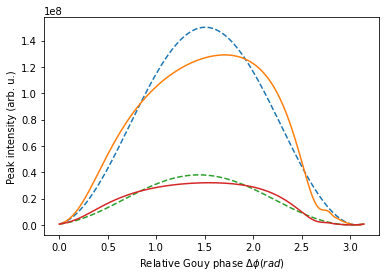

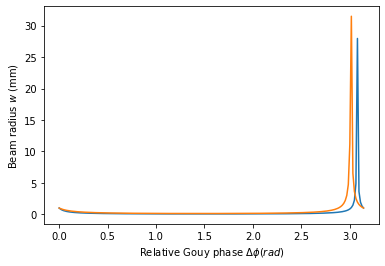

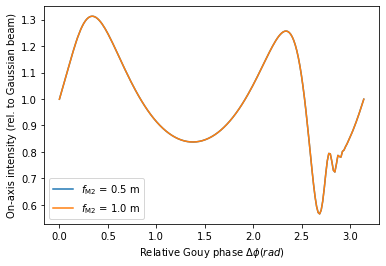

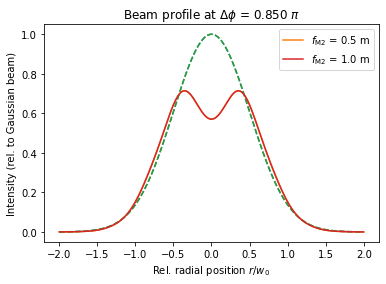

In [28]:
# Plot mode reconstruction
# ps = [0, 1, 2]
# coeffs = [1, 0, 0.1*np.exp(1j*0.)]

# Focal lengths of M2 lenses
fs_m2 = [0.5*u.m, 1*u.m]

num_points = 201
# zrs = np.linspace(-5, 5, num_points)
fields = np.zeros((len(fs_m2), num_points), dtype=np.complex128)
fields_00 = np.zeros((len(fs_m2), num_points), dtype=np.complex128)

for i_f, f_m2 in enumerate(fs_m2):

    # Position relative to beam waist at which reconstruction is shown
    beam_ = copy.copy(beam)
    coeffs_ = coeffs.copy()
    # print(np.angle(coeffs_))    
    z_offset = 0.

    # M2 configuration
    abcd = abcd_thin_lens(f_m2.to('m').value)
    beam_.apply_abcd(abcd)
    # Calculate decomposition coefficients of beam after M2 lens by adding additional Gouy phase of
    # of Laguerre-Gauss modes from M2 lens to coefficents of beam before M2 lens
    coeffs_ = [coeff*np.exp(-1j*(2*p+1)*beam_.psi) for p, coeff in zip(ps, coeffs)]
    # print(np.angle(coeffs_))    
    z_offset = -beam_.z

    psis = np.linspace(0.*np.pi, 1*np.pi, num_points)
    # print(psis)
    # print(beam_.psi)
    psis_ = psis + beam_.psi
    zrs = np.tan(psis_)
    # print('zrs')
    # print(zrs)
    # zrs = np.linspace(-5, 5, num_points)    

    # print(f_m2)
    # print(z_offset)
    # print(beam_.zr)
    # print(z_offset/beam_.zr)

    ws = np.zeros(num_points)
    for i, zr_ in enumerate(zrs):
        beam__ = copy.copy(beam_)
        q_ = beam_.q+z_offset+zr_*beam_.zr
        beam__.q = q_
        # print(beam__.w)
        fields[i_f, i] = np.sum(
            [coeff*beam__.laguerre_gauss(p, 0, 0, 0) for p, coeff in zip(ps, coeffs_)], axis=0)
        fields_00[i_f, i] = beam__.laguerre_gauss(0, 0, 0, 0)
        ws[i] = beam__.w
    plt.figure('Peak intensity')        
    ax_pi = plt.gca()
    ax_pi.plot(psis, np.abs(fields_00[i_f])**2, linestyle='--')
    ax_pi.plot(psis, np.abs(fields[i_f])**2)
    ax_pi.set_xlabel(r'Relative Gouy phase $\Delta\phi (rad)$')
    ax_pi.set_ylabel('Peak intensity (arb. u.)')
    plt.figure('Beam radius')        
    plt.plot(psis, 1e3*ws)
    ax_br = plt.gca()
    ax_br.set_xlabel(r'Relative Gouy phase $\Delta\phi (rad)$')
    ax_br.set_ylabel(r'Beam radius $w$ (mm)')
    # Recreating figure such as Fig. 8 of Bey2013
    plt.figure('Relative peak intensity')
    ax_rpi = plt.gca()
    ax_rpi.plot(
        psis, np.abs(fields[i_f])**2/np.abs(fields_00[i_f])**2,
        label=rf'$f_\mathrm{{M2}}$ = {f_m2}')
    ax_rpi.set_xlabel(r'Relative Gouy phase $\Delta\phi (rad)$')
    ax_rpi.set_ylabel('On-axis intensity (rel. to Gaussian beam)')

    psi_ = 0.85*np.pi
    zr_ = np.tan(psi_+beam_.psi)
    print(zr_)
    # zr_ = 0
    beam__ = copy.copy(beam_)
    beam__.q = beam_.q+z_offset+zr_*beam_.zr
    # print(beam__.q)
    # print(beam__.get_gouy_phase(q=beam__.q)-beam__.get_gouy_phase(q=beam_.q))
    # print(beam__.psi)
    # print(np.angle(coeffs_))
    # print(np.angle([coeff*beam__.laguerre_gauss(p, 0, 0, 0) for p, coeff in zip(ps, coeffs_)]))
    max_r = 2*beam__.w*u.m
    mask = (x >= -max_r) & (x <= max_r)
    # Reconstruction        
    r = x[mask].to('m').value
    r_mm = x[mask].to('mm').value
    reconst = np.sum(
        [coeff*beam__.laguerre_gauss(p, 0, r, 0) for p, coeff in zip(ps, coeffs_)], axis=0)
    y_reconst = np.abs(reconst)**2
    # Plot mode decomposition result
    plt.figure('Mode')
    ax_m = plt.gca()
    ax_m.plot(
        r_mm/(1e3*beam__.w),
        np.abs(beam__.laguerre_gauss(0, 0, r, 0))**2/(np.abs(beam__.laguerre_gauss(0, 0, 0, 0))**2),
        linestyle='--',
        )
    ax_m.plot(
        r_mm/(1e3*beam__.w), y_reconst/(np.abs(beam__.laguerre_gauss(0, 0, 0, 0))**2),
        label=rf'$f_\mathrm{{M2}}$ = {f_m2}',        
        )
    ax_m.set_title(rf'Beam profile at $\Delta\phi$ = {psi_/np.pi:.3f} $\pi$')
    ax_m.set_xlabel(r'Rel. radial position $r/w_0$')
    ax_m.set_ylabel('Intensity (rel. to Gaussian beam)')

ax_rpi.legend()
ax_m.legend()